# Aggregation

In [24]:
import pandas as pd
from dfply import *
import numpy as np
from more_dfply import ifelse

## What is aggregation?

The act of collapsing many rows into few rows.

## Example - Baseball pitching

In [3]:
pitching_raw = pd.read_csv('./data/baseball/core/Pitching.csv') 
pitching = (pitching_raw >>
             mutate(id = pitching_raw.index))
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,id
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,7,NaN,0,146.0,0,42,NaN,NaN,NaN,0
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,7,NaN,0,1291.0,0,292,NaN,NaN,NaN,1
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,2,NaN,0,14.0,0,9,NaN,NaN,NaN,2
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,20,NaN,0,1080.0,1,257,NaN,NaN,NaN,3
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,0,NaN,0,57.0,0,21,NaN,NaN,NaN,4


## Simple Aggregation

A **simple aggregation** collapses all rows into one row.

<img src="./img/simple_aggregation.png" width=800>

## Simple aggregation with `dfply.summarise`

In [4]:
(pitching 
 >> summarise(mean_era = mean(X.ERA),
              sd_era = sd(X.ERA),
              max_wins = X.W.max(),
              min_wins = X.W.min()))

,mean_era,sd_era,max_wins,min_wins
0,5.11792,5.466654,60,0


## <font color="red"> Exercise 1 </font>

The [dead ball era](https://en.wikipedia.org/wiki/Dead-ball_era) in MLB includes the year from about 1900 to 1918, which was known for a low number of runs per game.  After this period, the number of runs per game increased dramatically and one possible reason for this change was a changes made to the baseball at the start of the 1920 season.    

**Tasks:** Complete that following tasks using `pandas` and `dfply`

* Compute the average runs allowed per pitcher (column `R`) for the following two ranges of years: 
    * 1900-1919 and 
    * 1920-1939.  
* Is there evidence of a difference in the number of runs allowed for each era?

In [26]:
(pitching
        >> filter_by((X.yearID >= 1900) & (X.yearID < 1940))
        >> mutate(era = ifelse(X.yearID < 1920, 
                               "deadball", 
                               "postdeadball"))
        >> group_by(X.era)
        >> summarize(meanruns = mean(X.R))
       )

,era,meanruns
0,deadball,60.288580
1,postdeadball,48.409311


In [27]:
60.29/48.41

1.2454038421813676

There does appear to be an increase in mean runs comparing the deadball era to the post deadball era. There was a 25% increase in mean runs from the deadball era to the post deadball era.

## Group and Aggregate

Group and aggregate

* combines multiple filter + aggregates
* considers all possible groups.

<img src="./img/group_and_aggregate.png" width=800>

## Using `ifelse` to classify the years

In [28]:
from more_dfply import ifelse
eras = (pitching
        >> filter_by((X.yearID >= 1900) & (X.yearID < 1940))
        >> mutate(era = ifelse(X.yearID < 1920, 
                               "dead ball", 
                               "after dead ball"))
       )
eras >> head

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,HBP,BK,BFP,GF,R,SH,SF,GIDP,id,era
2628,baileha01,1900,1,BSN,NL,0,0,4,1,0,...,2.0,0,94.0,2,16,NaN,NaN,NaN,2628,dead ball
2629,bernhbi01,1900,1,PHI,NL,15,10,32,27,20,...,5.0,1,986.0,5,151,NaN,NaN,NaN,2629,dead ball
2630,breitte01,1900,1,CIN,NL,10,10,24,20,18,...,14.0,0,846.0,3,111,NaN,NaN,NaN,2630,dead ball
2631,callani01,1900,1,CHN,NL,13,16,32,32,32,...,22.0,0,1256.0,0,195,NaN,NaN,NaN,2631,dead ball
2632,carribi01,1900,1,NY1,NL,19,22,45,41,32,...,13.0,0,1493.0,4,224,NaN,NaN,NaN,2632,dead ball


<img src="./img/filter_group_aggregate.png" width=800>

What we did here is actually `filter + groupby + aggregate`

## Using `dfply.group_by` and `dfply.summarise` 

In [29]:
mean_runs = (eras
             >> group_by(X.era)
             >> summarise(mean_runs = mean(X.R)))
mean_runs

,era,mean_runs
0,after dead ball,48.409311
1,dead ball,60.288580


## Visualizing the data with `seaborn`

In [30]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

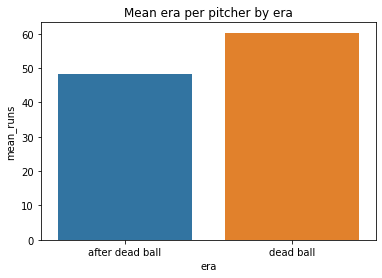

In [31]:
fig, ax = plt.subplots()
ax = sns.barplot(x = "era", y="mean_runs", data=mean_runs, ax = ax)
_ = ax.set_title("Mean era per pitcher by era")

## <font color="red"> Exercise 3 </font>

Compose the two queries into one piped expression (filter + mutate + group_by + summarise)

In [32]:
(pitching
        >> filter_by((X.yearID >= 1900) & (X.yearID < 1940))
        >> mutate(era = ifelse(X.yearID < 1920, 
                               "deadball", 
                               "postdeadball"))
        >> group_by(X.era)
        >> summarize(meanruns = mean(X.R))
       )

,era,meanruns
0,deadball,60.288580
1,postdeadball,48.409311


## Grouping by more than one category

* `group_by` accepts multiple columns
* Groups all combinations

## Example - Find all teams with 100+ wins in a season

#### `pandas` + `dfply`

In [14]:
(pitching
 >> select(X.yearID, X.teamID, X.W)
 >> group_by(X.yearID, X.teamID)
 >> summarise(total_wins = X.W.sum())
 >> ungroup
 >> filter_by(X.total_wins >= 100)
 >> arrange(X.yearID, X.total_wins, ascending=False)
 >> head
)

,teamID,yearID,total_wins
2905,HOU,2019,107
2908,LAN,2019,106
2912,NYA,2019,103
2911,MIN,2019,101
2868,BOS,2018,108


## So Iverson ... what's up with the `ungroup`?

* `pandas` messes with the `df.index` to group
* `dfply` adds a `_group_by` attribute to make this work without reindexing
* `ungroup` clears this attribute
* Do this before manipulating the resulting `df`

In [18]:
import numpy as np
df = pd.DataFrame({'group': ['A', 'B', 'C'],
                   'value': [1,2,3]
                  })
grouped_df = (df
              >> group_by(X.group))
grouped_df._grouped_by

['group']

In [19]:
ungrouped_df = (df
                >> group_by(X.group)
                >> ungroup)
ungrouped_df._grouped_by

## The last comparison might not be fair

Comparison is only fair if pitchers all pitch the same number of outs/games/innings.  Let's see if there is a difference between the eras in terms of outs pitched (`IPouts`).

In [20]:
mean_outs = (pitching
             >> select(X.IPouts, X.yearID)
             >> filter_by((X.yearID >= 1900) & (X.yearID < 1940))
             >> mutate(era = ifelse(X.yearID < 1920, 
                                    "dead ball", 
                                    "after dead ball"))
             >> group_by(X.era)
             >> summarise(mean_outs = mean(X.IPouts)))
mean_outs

,era,mean_outs
0,after dead ball,308.190136
1,dead ball,390.134259


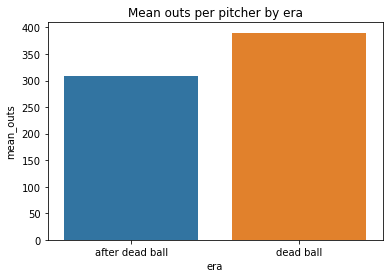

In [23]:
fig, ax = plt.subplots()
ax = sns.barplot(x = "era", y="mean_outs", data=mean_outs, ax = ax)
_ = ax.set_title("Mean outs per pitcher by era")

## A more fair comparison

Instead of comparing the era's on a per-pitcher basis, let's compare on a per year basis.  We will

1. Compute the total runs and total IPouts per year.
2. Compute the ratio of these totals for each year.
3. Compute the average value of the ratio for each era

In [36]:
mean_runs_per_out = (pitching
                     >> select(X.IPouts, X.yearID, X.R)
                     >> filter_by((X.yearID >= 1900) & (X.yearID < 1940))
                     >> group_by(X.yearID)
                     >> summarise(total_runs = X.R.sum(),
                                  total_ipouts = X.IPouts.sum())
                     >> ungroup
                     >> mutate(runs_per_out = X.total_runs/X.total_ipouts,
                               era = ifelse(X.yearID < 1920, 
                                            "dead ball", 
                                            "after dead ball"))
                     >> group_by(X.era)
                     >> summarise(mean_runs_per_out = mean(X.runs_per_out))
                    )
mean_runs_per_out

,era,mean_runs_per_out
0,after dead ball,0.182218
1,dead ball,0.149920


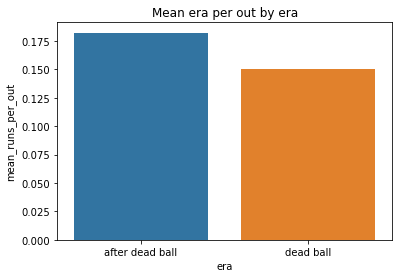

In [26]:
fig, ax = plt.subplots()
ax = sns.barplot(x = "era", y="mean_runs_per_out", data=mean_runs_per_out, ax = ax)
_ = ax.set_title("Mean era per out by era")

## <font color="red"> Exercise 4 </font>

It would be easier to understand this result if we were computing runs on a per-game basis.  Redo the last problem, both this time compute `mean_runs_per_9_innings`.  **Hint:** There are 27 outs in a 9 inning game.

In [38]:
mean_runs_per_9_innings = (pitching
                     >> select(X.IPouts, X.yearID, X.R)
                     >> filter_by((X.yearID >= 1900) & (X.yearID < 1940))
                     >> group_by(X.yearID)
                     >> summarise(total_runs = X.R.sum(),
                                  total_innings = (X.IPouts.sum())/3)
                     >> ungroup
                     >> mutate(runs_per_inning = X.total_runs/X.total_innings,
                               era = ifelse(X.yearID < 1920, 
                                            "dead ball", 
                                            "after dead ball"))
                     >> group_by(X.era)
                     >> summarise(mean_runs_per_9_innings = mean(X.runs_per_inning)*9)
                    )
mean_runs_per_9_innings

,era,mean_runs_per_9_innings
0,after dead ball,4.919895
1,dead ball,4.047843


## <font color="red"> Exercise 5 </font>

Compute and plot the average home runs per game allowed per year for all years in the pitching table.  To accomplish this task, you should

1. Aggregate total `HR` and `IPouts` for each year.
1. Create a `games_pitched`, which is computed by dividing total inning pitched outs `IPouts` by 27, the number of outs in a game.
2. Create a `hr_per_game` column by dividing the total `HR` for each year by `games_pitched` for each year.
4. Make line plot of the results. You will need to create a new column `HR_per_inning` then perform the group and aggregate. You can use [seaborn's lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html) to make the graph.

In [39]:
pitching.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP',
       'id', 'era'],
      dtype='object')

In [47]:
hr_per_game = (pitching
    >> group_by(X.yearID)
    >> summarize(HR = X.HR.sum(),
                 games_pitched = X.IPouts.sum()/27
                )
    >> mutate(hr_per_game = X.HR/X.games_pitched)

)

<AxesSubplot:xlabel='yearID', ylabel='hr_per_game'>

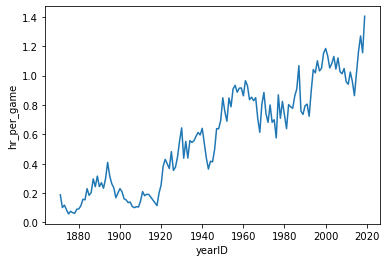

In [48]:
sns.lineplot(x = "yearID", y = "hr_per_game", data = hr_per_game)
